<a href="https://colab.research.google.com/github/Viroslav/Projects/blob/main/IMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
#sharper plots
%config InlineBackend.figure_format = 'retina'
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

In [ ]:
import tarfile
from io import BytesIO

import requests

url = "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"


def load_imdb_dataset(extract_path, overwrite=False):
    # check if existed already
    if (
        os.path.isfile(os.path.join(extract_path, "aclImdb", "README"))
        and not overwrite
    ):
        print("IMDB dataset is already in place.")
        return

    print("Downloading the dataset from:  ", url)
    response = requests.get(url)

    tar = tarfile.open(mode="r:gz", fileobj=BytesIO(response.content))

    data = tar.extractall(extract_path)

In [ ]:
# for Jupyter-book, we copy data from GitHub, locally, to save Internet traffic,
# you can specify the data/ folder from the root of your cloned
# https://github.com/Yorko/mlcourse.ai repo, to save Internet traffic
DATA_PATH = "../../_static/data/"

load_imdb_dataset(extract_path=DATA_PATH)

In [ ]:
# change if you have it in alternative location
PATH_TO_IMDB = DATA_PATH + "aclImdb"

reviews_train = load_files(
    os.path.join(PATH_TO_IMDB, "train"), categories=["pos", "neg"]
)
text_train, y_train = reviews_train.data, reviews_train.target

reviews_test = load_files(os.path.join(PATH_TO_IMDB, "test"), categories=["pos", "neg"])
text_test, y_test = reviews_test.data, reviews_test.target

In [ ]:
print("Number of documents in training data: %d" % len(text_train))
print(np.bincount(y_train))
print("Number of documents in test data: %d" % len(text_test))
print(np.bincount(y_test))

Number of documents in training data: 25000
[12500 12500]
Number of documents in test data: 25000
[12500 12500]


In [ ]:
print(text_train[1])

b'Words can\'t describe how bad this movie is. I can\'t explain it by writing only. You have too see it for yourself to get at grip of how horrible a movie really can be. Not that I recommend you to do that. There are so many clich\xc3\xa9s, mistakes (and all other negative things you can imagine) here that will just make you cry. To start with the technical first, there are a LOT of mistakes regarding the airplane. I won\'t list them here, but just mention the coloring of the plane. They didn\'t even manage to show an airliner in the colors of a fictional airline, but instead used a 747 painted in the original Boeing livery. Very bad. The plot is stupid and has been done many times before, only much, much better. There are so many ridiculous moments here that i lost count of it really early. Also, I was on the bad guys\' side all the time in the movie, because the good guys were so stupid. "Executive Decision" should without a doubt be you\'re choice over this one, even the "Turbulenc

#2. A Simple Word Count
First, we will create a dictionary of all the words using CountVectorizer#

In [ ]:
cv = CountVectorizer()
cv.fit(text_train)

len(cv.vocabulary_)

74849

In [ ]:
print(cv.get_feature_names()[:50])
print(cv.get_feature_names()[50000:50050])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['00', '000', '0000000000001', '00001', '00015', '000s', '001', '003830', '006', '007', '0079', '0080', '0083', '0093638', '00am', '00pm', '00s', '01', '01pm', '02', '020410', '029', '03', '04', '041', '05', '050', '06', '06th', '07', '08', '087', '089', '08th', '09', '0f', '0ne', '0r', '0s', '10', '100', '1000', '1000000', '10000000000000', '1000lb', '1000s', '1001', '100b', '100k', '100m']
['pincher', 'pinchers', 'pinches', 'pinching', 'pinchot', 'pinciotti', 'pine', 'pineal', 'pineapple', 'pineapples', 'pines', 'pinet', 'pinetrees', 'pineyro', 'pinfall', 'pinfold', 'ping', 'pingo', 'pinhead', 'pinheads', 'pinho', 'pining', 'pinjar', 'pink', 'pinkerton', 'pinkett', 'pinkie', 'pinkins', 'pinkish', 'pinko', 'pinks', 'pinku', 'pinkus', 'pinky', 'pinnacle', 'pinnacles', 'pinned', 'pinning', 'pinnings', 'pinnochio', 'pinnocioesque', 'pino', 'pinocchio', 'pinochet', 'pinochets', 'pinoy', 'pinpoint', 'pinpoints', 'pins', 'pinsent']


In [ ]:
X_train = cv.transform(text_train)
X_train

<25000x74849 sparse matrix of type '<class 'numpy.int64'>'
	with 3445861 stored elements in Compressed Sparse Row format>

In [ ]:
print(text_train[19726])

b'This movie is terrible but it has some good effects.'


In [ ]:
X_train[19726].nonzero()[1]

array([ 9881, 21020, 28068, 29999, 34585, 34683, 44147, 61617, 66150,
       66562], dtype=int32)

Third, we will apply the same operations to the test set

In [ ]:
X_test = cv.transform(text_test)

The next step is to train Logistic Regression.

In [ ]:
%%time
logit = LogisticRegression(solver="lbfgs", n_jobs=-1, random_state=7)
logit.fit(X_train, y_train)

CPU times: user 99.7 ms, sys: 90 ms, total: 190 ms
Wall time: 5.24 s


LogisticRegression(n_jobs=-1, random_state=7)

In [ ]:
round(logit.score(X_train, y_train), 3), round(logit.score(X_test, y_test), 3),

(0.981, 0.864)

The coefficients of the model can be beautifully displayed.



In [ ]:
def visualize_coefficients(classifier, feature_names, n_top_features=25):
    # get coefficients with large absolute values
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    # plot them
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(
        np.arange(1, 1 + 2 * n_top_features),
        feature_names[interesting_coefficients],
        rotation=60,
        ha="right",
    );

In [ ]:
def plot_grid_scores(grid, param_name):
    plt.plot(
        grid.param_grid[param_name],
        grid.cv_results_["mean_train_score"],
        color="green",
        label="train",
    )
    plt.plot(
        grid.param_grid[param_name],
        grid.cv_results_["mean_test_score"],
        color="red",
        label="test",
    )
    plt.legend();

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


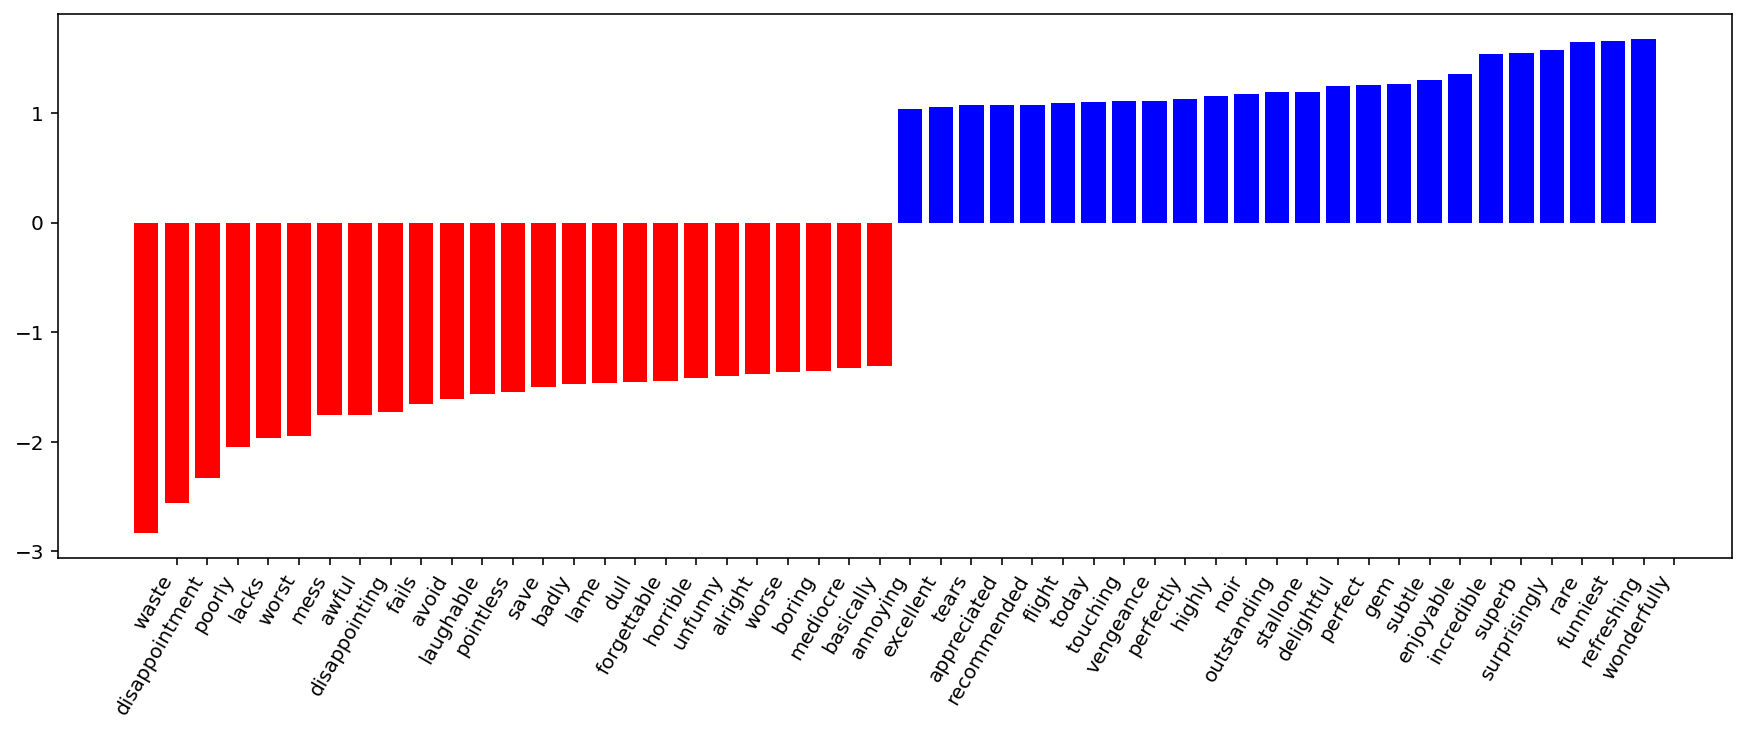

In [ ]:
visualize_coefficients(logit, cv.get_feature_names());

In [ ]:
logit.coef_

array([[-0.10582561, -0.04313309, -0.00940533, ...,  0.00108024,
        -0.05129497, -0.01329581]])